In [ ]:
# זו שורה שעוזרת לעשות ריענון לקובץ, כשמתחילים להריץ מחדש, יש להריץ את העמודה הזו קודם
# ניקוי כל המשתנים שהוגדרו
%reset -f

In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import seaborn as sns
import statsmodels.api as sm

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving add age of car.xlsx to add age of car (2).xlsx


In [ ]:
file_name = list(uploaded.keys())[0]
xls = pd.ExcelFile(file_name)

In [ ]:
# טעינת הגליון והורדת העמודה הראשונה משום שהיא טרנפורמציה של העמודה השנייה
df = pd.read_excel(xls, sheet_name='צריכת דלק קובץ מאושר')
df = df.iloc[ :, 1:]

In [ ]:
# הצגת ראש גיליון הנתונים
print(df.head())

   Vehicle Age   MAKE    MODEL VEHICLE CLASS  ENGINE SIZE  CYLINDERS  \
0           22  ACURA    1.6EL       COMPACT          1.6          4   
1           22  ACURA    1.6EL       COMPACT          1.6          4   
2           22  ACURA    3.2TL      MID-SIZE          3.2          6   
3           22  ACURA    3.5RL      MID-SIZE          3.5          6   
4           22  ACURA  INTEGRA    SUBCOMPACT          1.8          4   

  TRANSMISSION FUEL  FUEL CONSUMPTION  HWY (L/100 km)  COMB (L/100 km)  \
0           A4    X               9.2             6.7              8.1   
1           M5    X               8.5             6.5              7.6   
2          AS5    Z              12.2             7.4             10.0   
3           A4    Z              13.4             9.2             11.5   
4           A4    X              10.0             7.0              8.6   

   COMB (mpg)  EMISSIONS  
0          35        186  
1          37        175  
2          28        230  
3          25 

In [ ]:

# הדפסת כמות התצפיות וכמות המשתנים
num_rows, num_columns = df.shape
print(f"Number of observations: {num_rows}")
print(f"Number of variables: {num_columns}")

Number of observations: 22556
Number of variables: 13


In [ ]:
# בדיקה האם כל התצפיות מלאות (ללא ערכים חסרים)
missing_values = df.isnull().sum().sum()
if missing_values == 0:
    print("All observations are complete (no missing values).")
else:
    print(f"Warning: There are {missing_values} missing values in the dataset.")

All observations are complete (no missing values).


#The above cell we know that there are no missing values in the original DataFrame


In [ ]:
# Display data types for each column in an organized way
print("Data Types for Each Column:")
df.dtypes

Data Types for Each Column:


,0
Vehicle Age,int64
MAKE,object
MODEL,object
VEHICLE CLASS,object
ENGINE SIZE,float64
CYLINDERS,int64
TRANSMISSION,object
FUEL,object
FUEL CONSUMPTION,float64
HWY (L/100 km),float64


In [ ]:
# בחירת עמודות מספריות ללא 'CYLINDERS'
numerical_columns = df.select_dtypes(include=['number']).columns
numerical_columns = numerical_columns.drop('CYLINDERS', errors='ignore')

numerical_columns

Index(['Vehicle Age', 'ENGINE SIZE', 'FUEL CONSUMPTION', 'HWY (L/100 km)',
       'COMB (L/100 km)', 'COMB (mpg)', 'EMISSIONS'],
      dtype='object')

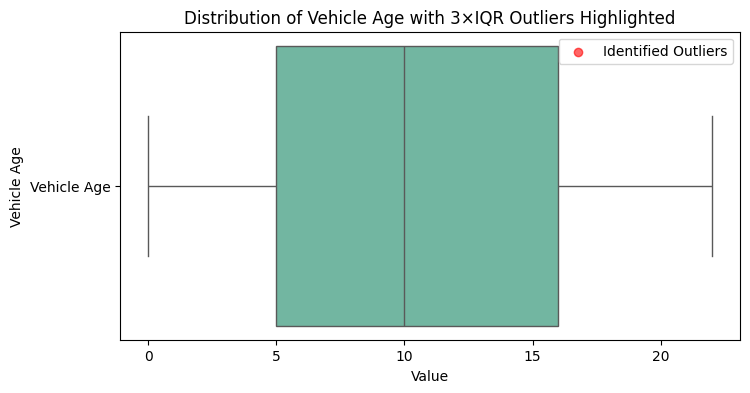

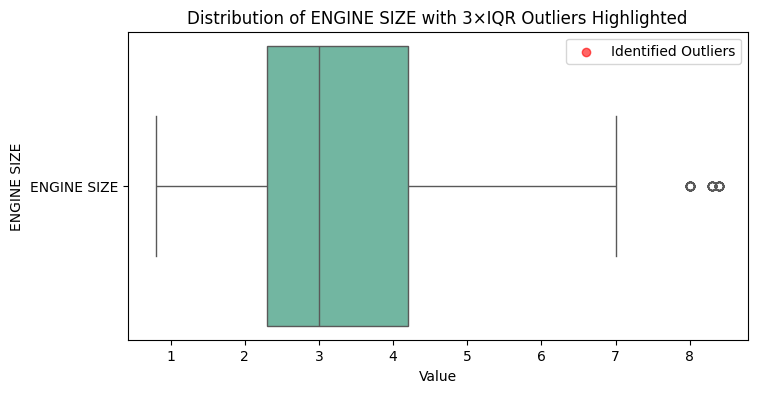

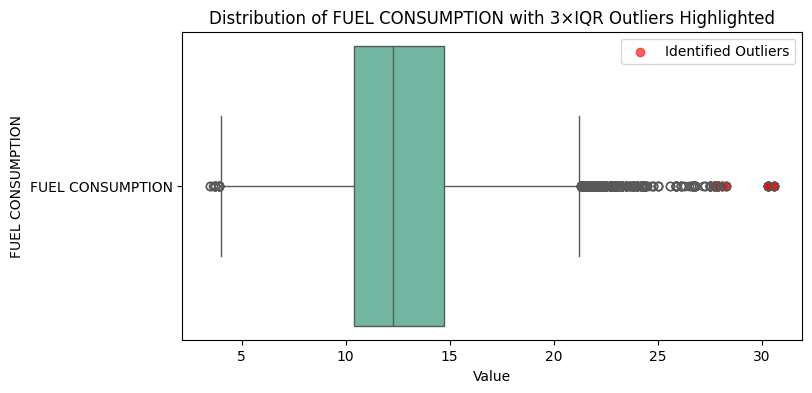

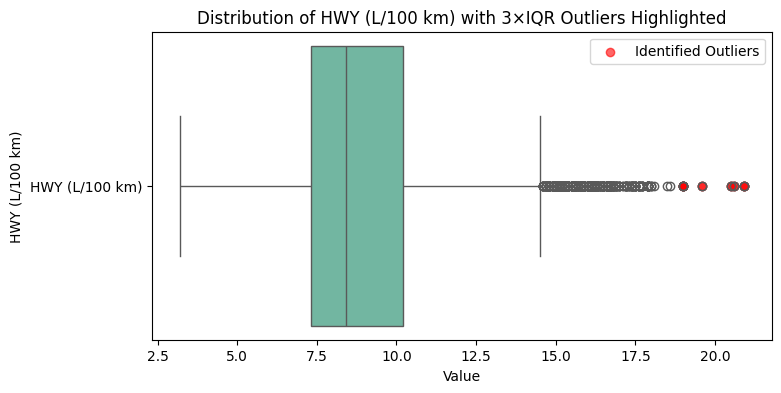

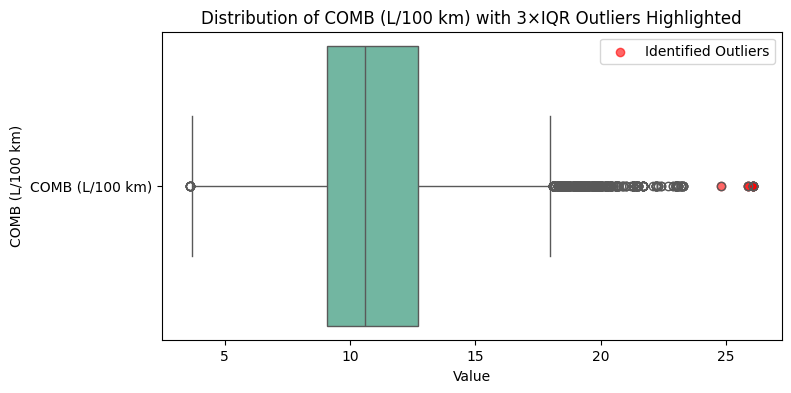

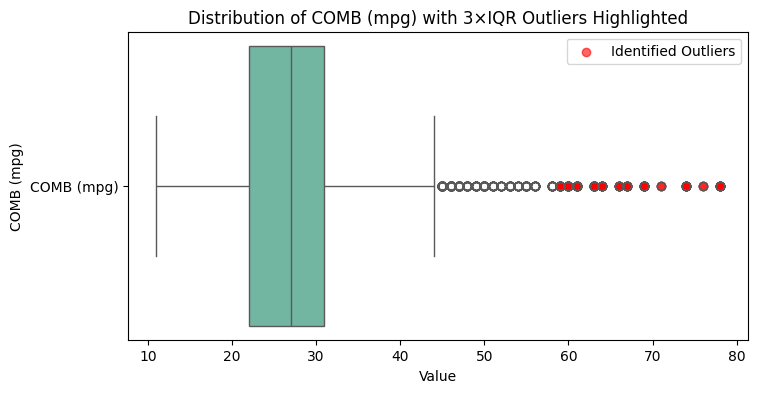

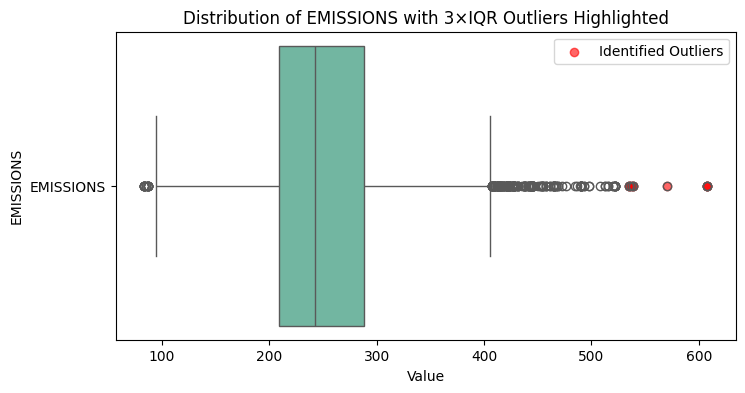

Number of observations before cleaning: 22556
Number of observations after cleaning: 22419
Number of removed observations: 137


In [ ]:
# זיהוי חריגים לפי 3×IQR מבלי להסיר אותם
outliers_mask = pd.Series(False, index=df.index)

# יצירת Boxplot נפרד לכל משתנה עם סימון ערכים שנופלים תחת ההגדרה של 3×IQR
for col in numerical_columns:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1

    # זיהוי ערכים שנופלים תחת ההגדרה של 3×IQR אך לא מוסרים בפועל
    col_outliers_mask = (df[col] < (Q1 - 3.0 * IQR)) | (df[col] > (Q3 + 3.0 * IQR))
    col_outliers_indices = df.index[col_outliers_mask]

    # יצירת Boxplot עבור המשתנה
    plt.figure(figsize=(8, 4))
    sns.boxplot(data=df[[col]], orient="h", palette="Set2")

    # סימון הערכים החריגים בנקודות אדומות בתוך ה-Boxplot
    plt.scatter(df.loc[col_outliers_indices, col], [0] * len(col_outliers_indices),
                color='red', alpha=0.6, label="Identified Outliers")

    plt.title(f"Distribution of {col} with 3×IQR Outliers Highlighted")
    plt.xlabel("Value")
    plt.ylabel(col)
    plt.legend()
    plt.show()

# **הסרת החריגים** מכל השורות בהן קיים לפחות ערך חריג אחד
outliers_mask = pd.Series(False, index=df.index)

for col in numerical_columns:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1

    # זיהוי ערכים חריגים
    col_outliers_mask = (df[col] < (Q1 - 3.0 * IQR)) | (df[col] > (Q3 + 3.0 * IQR))
    outliers_mask |= col_outliers_mask  # שילוב המסכות לכל העמודות

df_clean = df[~outliers_mask]  # יצירת DataFrame נקי מהחריגים

# **הדפסת מספר התצפיות לפני ואחרי**
original_observations = df.shape[0]
cleaned_observations = df_clean.shape[0]

print(f"Number of observations before cleaning: {original_observations}")
print(f"Number of observations after cleaning: {cleaned_observations}")
print(f"Number of removed observations: {original_observations - cleaned_observations}")

In [ ]:
df.isna().any()

,0
Vehicle Age,False
MAKE,False
MODEL,False
VEHICLE CLASS,False
ENGINE SIZE,False
CYLINDERS,False
TRANSMISSION,False
FUEL,False
FUEL CONSUMPTION,False
HWY (L/100 km),False


In [ ]:
# Display descriptive statistics
print("\nDescriptive Statistical Measures:")
print(df.describe())


Descriptive Statistical Measures:
        Vehicle Age   ENGINE SIZE     CYLINDERS  FUEL CONSUMPTION  \
count  22556.000000  22556.000000  22556.000000      22556.000000   
mean      10.445558      3.356646      5.854141         12.763513   
std        6.298269      1.335425      1.819597          3.500999   
min        0.000000      0.800000      2.000000          3.500000   
25%        5.000000      2.300000      4.000000         10.400000   
50%       10.000000      3.000000      6.000000         12.300000   
75%       16.000000      4.200000      8.000000         14.725000   
max       22.000000      8.400000     16.000000         30.600000   

       HWY (L/100 km)  COMB (L/100 km)    COMB (mpg)     EMISSIONS  
count    22556.000000     22556.000000  22556.000000  22556.000000  
mean         8.919126        11.034341     27.374534    250.068452  
std          2.274764         2.910920      7.376982     59.355276  
min          3.200000         3.600000     11.000000     83.000000 

In [ ]:
# Display frequency tables for categorical variables
categorical_columns = df.select_dtypes(include=['object']).columns
for col in categorical_columns:
    print(f"\nFrequency Table for {col}:")
    print(df[col].value_counts())



Frequency Table for MAKE:
MAKE
CHEVROLET        1725
BMW              1490
GMC              1357
FORD             1276
MERCEDES-BENZ     935
                 ... 
ALFA ROMEO          8
SRT                 4
GENESIS             4
BUGATTI             3
PLYMOUTH            2
Name: count, Length: 87, dtype: int64

Frequency Table for MODEL:
MODEL
JETTA                        89
MUSTANG                      88
RANGER                       61
SENTRA                       58
TACOMA                       57
                             ..
Levante Modena V8             1
Levante Modena                1
Levante GT                    1
Ghibli Modena AWD             1
Tundra Hybrid 4WD TRD PRO     1
Name: count, Length: 4242, dtype: int64

Frequency Table for VEHICLE CLASS:
VEHICLE CLASS
SUV                         2640
COMPACT                     2636
MID-SIZE                    2300
PICKUP TRUCK - STANDARD     1689
SUBCOMPACT                  1559
FULL-SIZE                   1086
TWO-SEATER    

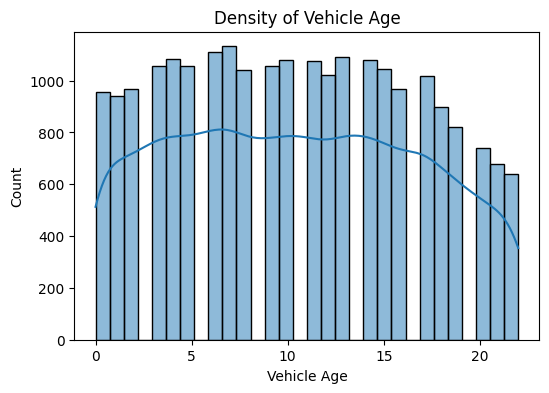

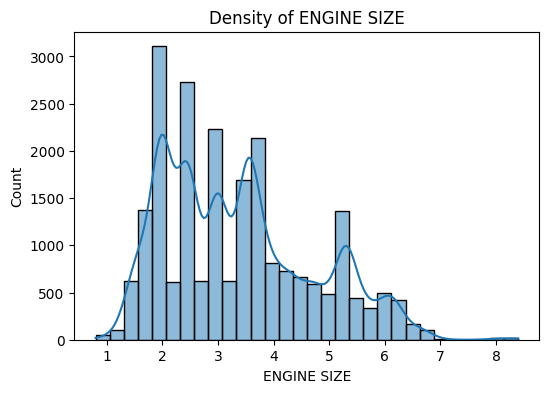

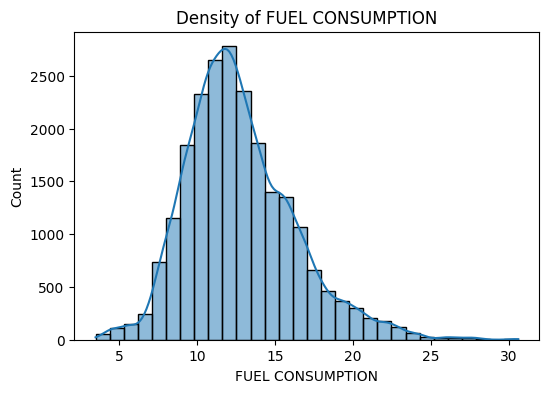

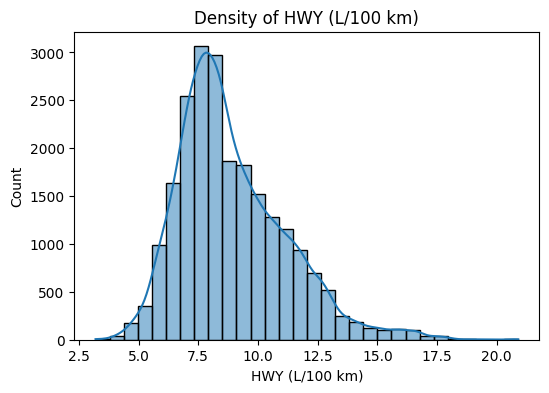

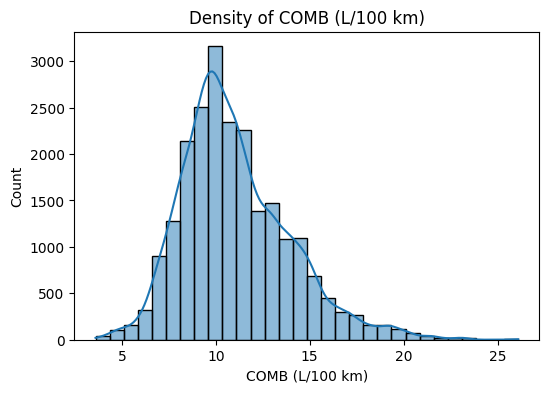

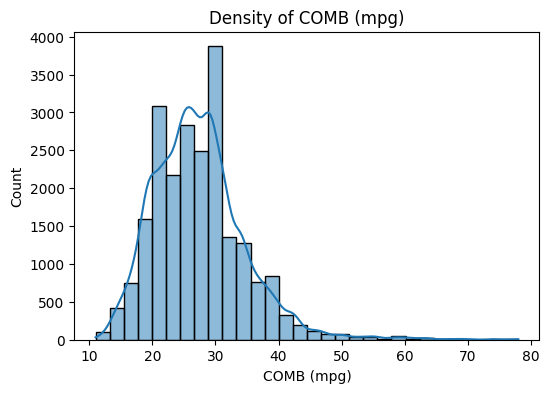

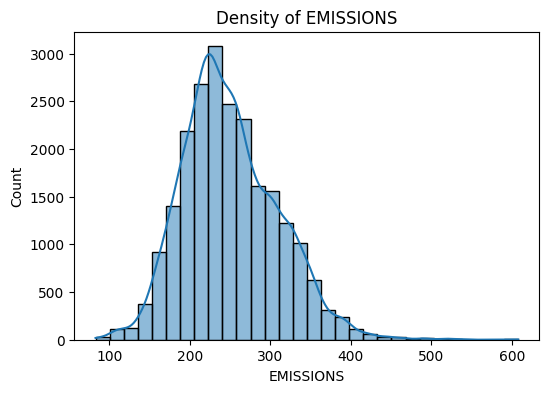

In [ ]:
for col in numerical_columns:
    plt.figure(figsize=(6, 4))
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f'Density of {col}')
    plt.show()

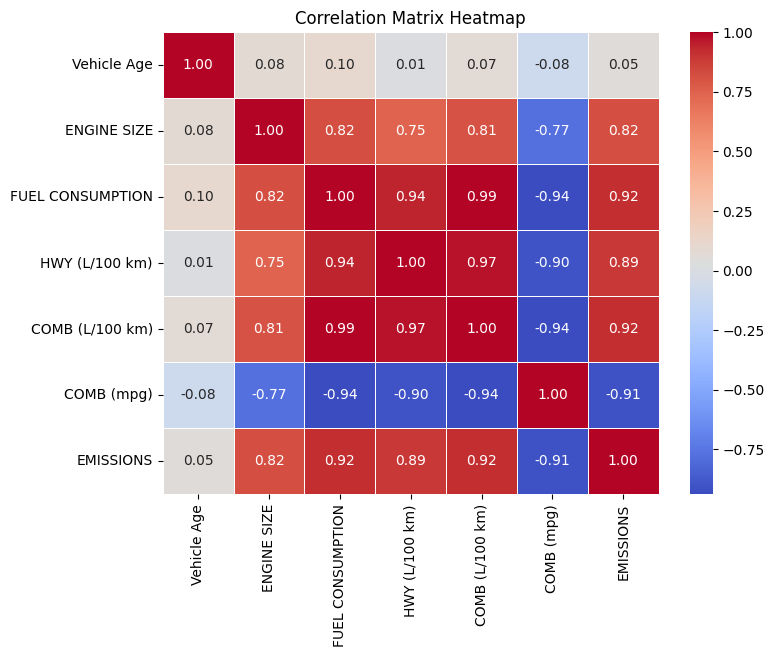

   Vehicle Age   MAKE    MODEL VEHICLE CLASS  ENGINE SIZE  CYLINDERS  \
0           22  ACURA    1.6EL       COMPACT          1.6          4   
1           22  ACURA    1.6EL       COMPACT          1.6          4   
2           22  ACURA    3.2TL      MID-SIZE          3.2          6   
3           22  ACURA    3.5RL      MID-SIZE          3.5          6   
4           22  ACURA  INTEGRA    SUBCOMPACT          1.8          4   

  TRANSMISSION FUEL  FUEL CONSUMPTION  HWY (L/100 km)  COMB (L/100 km)  \
0           A4    X               9.2             6.7              8.1   
1           M5    X               8.5             6.5              7.6   
2          AS5    Z              12.2             7.4             10.0   
3           A4    Z              13.4             9.2             11.5   
4           A4    X              10.0             7.0              8.6   

   COMB (mpg)  EMISSIONS  
0          35        186  
1          37        175  
2          28        230  
3          25 

In [ ]:
# חישוב מטריצת הקורלציות עבור המשתנים הכמותיים
correlation_matrix = df_clean[numerical_columns].corr()

# יצירת מפת חום להצגת מטריצת הקורלציות
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)

# כותרת
plt.title("Correlation Matrix Heatmap")

# הצגת הגרף
plt.show()
print(df.head())

In [ ]:
# הבטחה שהנתונים קיימים
if 'df_clean' not in locals():
    raise NameError("The dataset 'df_clean' is not defined.")

In [ ]:
# סינון רק למשתנים מספריים ואיכותיים
numerical_columns = df_clean.select_dtypes(include=[np.number]).columns.tolist()
categorical_columns = df_clean.select_dtypes(include=['object', 'category']).columns.tolist()


In [ ]:
# הבטחה שכל הנתונים המספריים הם באמת מספריים
for col in numerical_columns:
  df_clean.loc[:, col] = pd.to_numeric(df_clean[col], errors='coerce')

In [ ]:
df_clean

,Vehicle Age,MAKE,MODEL,VEHICLE CLASS,ENGINE SIZE,CYLINDERS,TRANSMISSION,FUEL,FUEL CONSUMPTION,HWY (L/100 km),COMB (L/100 km),COMB (mpg),EMISSIONS
0,22,ACURA,1.6EL,COMPACT,1.6,4,A4,X,9.2,6.7,8.1,35,186
1,22,ACURA,1.6EL,COMPACT,1.6,4,M5,X,8.5,6.5,7.6,37,175
2,22,ACURA,3.2TL,MID-SIZE,3.2,6,AS5,Z,12.2,7.4,10.0,28,230
3,22,ACURA,3.5RL,MID-SIZE,3.5,6,A4,Z,13.4,9.2,11.5,25,264
4,22,ACURA,INTEGRA,SUBCOMPACT,1.8,4,A4,X,10.0,7.0,8.6,33,198
...,...,...,...,...,...,...,...,...,...,...,...,...,...
22551,0,Volvo,XC40 T5 AWD,SUV: Small,2.0,4,AS8,Z,10.7,7.7,9.4,30,219
22552,0,Volvo,XC60 B5 AWD,SUV: Small,2.0,4,AS8,Z,10.5,8.1,9.4,30,219
22553,0,Volvo,XC60 B6 AWD,SUV: Small,2.0,4,AS8,Z,11.0,8.7,9.9,29,232
22554,0,Volvo,XC90 T5 AWD,SUV: Standard,2.0,4,AS8,Z,11.5,8.4,10.1,28,236


In [ ]:
# הסרת עמודות עם ערכים חסרים רבים מדי
df_clean = df_clean.dropna(axis=1, thresh=int(0.8 * len(df_clean)))
print(df.head())

   Vehicle Age   MAKE    MODEL VEHICLE CLASS  ENGINE SIZE  CYLINDERS  \
0           22  ACURA    1.6EL       COMPACT          1.6          4   
1           22  ACURA    1.6EL       COMPACT          1.6          4   
2           22  ACURA    3.2TL      MID-SIZE          3.2          6   
3           22  ACURA    3.5RL      MID-SIZE          3.5          6   
4           22  ACURA  INTEGRA    SUBCOMPACT          1.8          4   

  TRANSMISSION FUEL  FUEL CONSUMPTION  HWY (L/100 km)  COMB (L/100 km)  \
0           A4    X               9.2             6.7              8.1   
1           M5    X               8.5             6.5              7.6   
2          AS5    Z              12.2             7.4             10.0   
3           A4    Z              13.4             9.2             11.5   
4           A4    X              10.0             7.0              8.6   

   COMB (mpg)  EMISSIONS  
0          35        186  
1          37        175  
2          28        230  
3          25 

In [ ]:
df_clean

,Vehicle Age,MAKE,MODEL,VEHICLE CLASS,ENGINE SIZE,CYLINDERS,TRANSMISSION,FUEL,FUEL CONSUMPTION,HWY (L/100 km),COMB (L/100 km),COMB (mpg),EMISSIONS
0,22,ACURA,1.6EL,COMPACT,1.6,4,A4,X,9.2,6.7,8.1,35,186
1,22,ACURA,1.6EL,COMPACT,1.6,4,M5,X,8.5,6.5,7.6,37,175
2,22,ACURA,3.2TL,MID-SIZE,3.2,6,AS5,Z,12.2,7.4,10.0,28,230
3,22,ACURA,3.5RL,MID-SIZE,3.5,6,A4,Z,13.4,9.2,11.5,25,264
4,22,ACURA,INTEGRA,SUBCOMPACT,1.8,4,A4,X,10.0,7.0,8.6,33,198
...,...,...,...,...,...,...,...,...,...,...,...,...,...
22551,0,Volvo,XC40 T5 AWD,SUV: Small,2.0,4,AS8,Z,10.7,7.7,9.4,30,219
22552,0,Volvo,XC60 B5 AWD,SUV: Small,2.0,4,AS8,Z,10.5,8.1,9.4,30,219
22553,0,Volvo,XC60 B6 AWD,SUV: Small,2.0,4,AS8,Z,11.0,8.7,9.9,29,232
22554,0,Volvo,XC90 T5 AWD,SUV: Standard,2.0,4,AS8,Z,11.5,8.4,10.1,28,236


In [ ]:
# חישוב מטריצת הקורלציות מחדש
correlation_matrix = df_clean[numerical_columns].corr()


In [ ]:
# מציאת זוגות עם מתאם גבוה מ-0.9
high_corr_pairs = set()
for i in range(len(numerical_columns)):
    for j in range(i + 1, len(numerical_columns)):
        if abs(correlation_matrix.iloc[i, j]) > 0.9:
            high_corr_pairs.add((numerical_columns[i], numerical_columns[j]))


In [ ]:
# רשימת משתנים להסרה
variables_to_remove = set()
for var1, var2 in high_corr_pairs:
    if var1 in df_clean.columns and var2 in df_clean.columns:
        if df_clean[var1].isnull().sum() > df_clean[var2].isnull().sum():
            variables_to_remove.add(var1)
        else:
            variables_to_remove.add(var2)


In [ ]:
# הסרת המשתנים שנבחרו
print(f"Removing highly correlated variables: {variables_to_remove}")
df_clean = df_clean.drop(columns=variables_to_remove, errors='ignore')

Removing highly correlated variables: {'COMB (mpg)', 'HWY (L/100 km)', 'COMB (L/100 km)', 'CYLINDERS', 'EMISSIONS'}


In [ ]:
df_clean

,Vehicle Age,MAKE,MODEL,VEHICLE CLASS,ENGINE SIZE,TRANSMISSION,FUEL,FUEL CONSUMPTION
0,22,ACURA,1.6EL,COMPACT,1.6,A4,X,9.2
1,22,ACURA,1.6EL,COMPACT,1.6,M5,X,8.5
2,22,ACURA,3.2TL,MID-SIZE,3.2,AS5,Z,12.2
3,22,ACURA,3.5RL,MID-SIZE,3.5,A4,Z,13.4
4,22,ACURA,INTEGRA,SUBCOMPACT,1.8,A4,X,10.0
...,...,...,...,...,...,...,...,...
22551,0,Volvo,XC40 T5 AWD,SUV: Small,2.0,AS8,Z,10.7
22552,0,Volvo,XC60 B5 AWD,SUV: Small,2.0,AS8,Z,10.5
22553,0,Volvo,XC60 B6 AWD,SUV: Small,2.0,AS8,Z,11.0
22554,0,Volvo,XC90 T5 AWD,SUV: Standard,2.0,AS8,Z,11.5


In [ ]:
df

,Vehicle Age,MAKE,MODEL,VEHICLE CLASS,ENGINE SIZE,CYLINDERS,TRANSMISSION,FUEL,FUEL CONSUMPTION,HWY (L/100 km),COMB (L/100 km),COMB (mpg),EMISSIONS
0,22,ACURA,1.6EL,COMPACT,1.6,4,A4,X,9.2,6.7,8.1,35,186
1,22,ACURA,1.6EL,COMPACT,1.6,4,M5,X,8.5,6.5,7.6,37,175
2,22,ACURA,3.2TL,MID-SIZE,3.2,6,AS5,Z,12.2,7.4,10.0,28,230
3,22,ACURA,3.5RL,MID-SIZE,3.5,6,A4,Z,13.4,9.2,11.5,25,264
4,22,ACURA,INTEGRA,SUBCOMPACT,1.8,4,A4,X,10.0,7.0,8.6,33,198
...,...,...,...,...,...,...,...,...,...,...,...,...,...
22551,0,Volvo,XC40 T5 AWD,SUV: Small,2.0,4,AS8,Z,10.7,7.7,9.4,30,219
22552,0,Volvo,XC60 B5 AWD,SUV: Small,2.0,4,AS8,Z,10.5,8.1,9.4,30,219
22553,0,Volvo,XC60 B6 AWD,SUV: Small,2.0,4,AS8,Z,11.0,8.7,9.9,29,232
22554,0,Volvo,XC90 T5 AWD,SUV: Standard,2.0,4,AS8,Z,11.5,8.4,10.1,28,236


In [ ]:
# עדכון רשימת המשתנים המספריים לאחר הסרת משתנים
numerical_columns = df_clean.select_dtypes(include=[np.number]).columns.tolist()


In [ ]:
df_clean

,Vehicle Age,MAKE,MODEL,VEHICLE CLASS,ENGINE SIZE,TRANSMISSION,FUEL,FUEL CONSUMPTION
0,22,ACURA,1.6EL,COMPACT,1.6,A4,X,9.2
1,22,ACURA,1.6EL,COMPACT,1.6,M5,X,8.5
2,22,ACURA,3.2TL,MID-SIZE,3.2,AS5,Z,12.2
3,22,ACURA,3.5RL,MID-SIZE,3.5,A4,Z,13.4
4,22,ACURA,INTEGRA,SUBCOMPACT,1.8,A4,X,10.0
...,...,...,...,...,...,...,...,...
22551,0,Volvo,XC40 T5 AWD,SUV: Small,2.0,AS8,Z,10.7
22552,0,Volvo,XC60 B5 AWD,SUV: Small,2.0,AS8,Z,10.5
22553,0,Volvo,XC60 B6 AWD,SUV: Small,2.0,AS8,Z,11.0
22554,0,Volvo,XC90 T5 AWD,SUV: Standard,2.0,AS8,Z,11.5


In [ ]:
# יצירת עמודות אינטראקציה - מכפלה בין עמודות מספריות לעמודות איכותיות
for cat_col in categorical_columns:
    if cat_col in df_clean.columns:
        cat_codes = df_clean[cat_col].astype('category').cat.codes
        for num_col in numerical_columns:
            if num_col in df_clean.columns:
                df_clean[f"{num_col}_x_{cat_col}"] = df_clean[num_col] * cat_codes


In [ ]:
# עדכון רשימת המשתנים המספריים לאחר יצירת אינטראקציות
numerical_columns = df_clean.select_dtypes(include=[np.number]).columns.tolist()


In [ ]:
df_clean = df_clean.dropna(subset=['FUEL CONSUMPTION'])

In [ ]:
df_clean

,Vehicle Age,MAKE,MODEL,VEHICLE CLASS,ENGINE SIZE,TRANSMISSION,FUEL,FUEL CONSUMPTION,Vehicle Age_x_MAKE,ENGINE SIZE_x_MAKE,...,FUEL CONSUMPTION_x_MODEL,Vehicle Age_x_VEHICLE CLASS,ENGINE SIZE_x_VEHICLE CLASS,FUEL CONSUMPTION_x_VEHICLE CLASS,Vehicle Age_x_TRANSMISSION,ENGINE SIZE_x_TRANSMISSION,FUEL CONSUMPTION_x_TRANSMISSION,Vehicle Age_x_FUEL,ENGINE SIZE_x_FUEL,FUEL CONSUMPTION_x_FUEL
0,22,ACURA,1.6EL,COMPACT,1.6,A4,X,9.2,0,0.0,...,64.4,0,0.0,0.0,44,3.2,18.4,66,4.8,27.6
1,22,ACURA,1.6EL,COMPACT,1.6,M5,X,8.5,0,0.0,...,59.5,0,0.0,0.0,594,43.2,229.5,66,4.8,25.5
2,22,ACURA,3.2TL,MID-SIZE,3.2,AS5,Z,12.2,0,0.0,...,793.0,88,12.8,48.8,330,48.0,183.0,88,12.8,48.8
3,22,ACURA,3.5RL,MID-SIZE,3.5,A4,Z,13.4,0,0.0,...,884.4,88,14.0,53.6,44,7.0,26.8,88,14.0,53.6
4,22,ACURA,INTEGRA,SUBCOMPACT,1.8,A4,X,10.0,0,0.0,...,21560.0,374,30.6,170.0,44,3.6,20.0,66,5.4,30.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22551,0,Volvo,XC40 T5 AWD,SUV: Small,2.0,AS8,Z,10.7,0,172.0,...,43153.1,0,42.0,224.7,0,36.0,192.6,0,8.0,42.8
22552,0,Volvo,XC60 B5 AWD,SUV: Small,2.0,AS8,Z,10.5,0,172.0,...,42409.5,0,42.0,220.5,0,36.0,189.0,0,8.0,42.0
22553,0,Volvo,XC60 B6 AWD,SUV: Small,2.0,AS8,Z,11.0,0,172.0,...,44440.0,0,42.0,231.0,0,36.0,198.0,0,8.0,44.0
22554,0,Volvo,XC90 T5 AWD,SUV: Standard,2.0,AS8,Z,11.5,0,172.0,...,46690.0,0,44.0,253.0,0,36.0,207.0,0,8.0,46.0


In [ ]:
# חלוקת הנתונים ל-Train ו-Test (80%-20%)
train_data, test_data = train_test_split(df_clean, test_size=0.2, random_state=42)


In [ ]:
df

,Vehicle Age,MAKE,MODEL,VEHICLE CLASS,ENGINE SIZE,CYLINDERS,TRANSMISSION,FUEL,FUEL CONSUMPTION,HWY (L/100 km),COMB (L/100 km),COMB (mpg),EMISSIONS
0,22,ACURA,1.6EL,COMPACT,1.6,4,A4,X,9.2,6.7,8.1,35,186
1,22,ACURA,1.6EL,COMPACT,1.6,4,M5,X,8.5,6.5,7.6,37,175
2,22,ACURA,3.2TL,MID-SIZE,3.2,6,AS5,Z,12.2,7.4,10.0,28,230
3,22,ACURA,3.5RL,MID-SIZE,3.5,6,A4,Z,13.4,9.2,11.5,25,264
4,22,ACURA,INTEGRA,SUBCOMPACT,1.8,4,A4,X,10.0,7.0,8.6,33,198
...,...,...,...,...,...,...,...,...,...,...,...,...,...
22551,0,Volvo,XC40 T5 AWD,SUV: Small,2.0,4,AS8,Z,10.7,7.7,9.4,30,219
22552,0,Volvo,XC60 B5 AWD,SUV: Small,2.0,4,AS8,Z,10.5,8.1,9.4,30,219
22553,0,Volvo,XC60 B6 AWD,SUV: Small,2.0,4,AS8,Z,11.0,8.7,9.9,29,232
22554,0,Volvo,XC90 T5 AWD,SUV: Standard,2.0,4,AS8,Z,11.5,8.4,10.1,28,236


In [ ]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=['EMISSIONS'], errors='ignore')  # מוודא שהעמודה התלויה מוסרת
y = df['EMISSIONS']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
print(X_train.shape)
print(y_train.shape)

(18044, 12)
(18044,)


In [ ]:
print(X_train.shape)  # מספר השורות והעמודות לפני הסינון

(18044, 12)


In [ ]:
print(X_train.dtypes)

Vehicle Age           int64
MAKE                 object
MODEL                object
VEHICLE CLASS        object
ENGINE SIZE         float64
CYLINDERS             int64
TRANSMISSION         object
FUEL                 object
FUEL CONSUMPTION    float64
HWY (L/100 km)      float64
COMB (L/100 km)     float64
COMB (mpg)            int64
dtype: object


In [ ]:
X_train.isna().any().any()

np.False_

In [ ]:
X_train

,Vehicle Age,MAKE,MODEL,VEHICLE CLASS,ENGINE SIZE,CYLINDERS,TRANSMISSION,FUEL,FUEL CONSUMPTION,HWY (L/100 km),COMB (L/100 km),COMB (mpg)
2777,19,TOYOTA,CAMRY SOLARA CONVERTIBLE,SUBCOMPACT,3.0,6,A4,X,12.5,8.4,10.7,26
8081,13,CHEVROLET,EXPRESS CARGO CONV AWD,VAN - CARGO,5.3,8,A4,X,16.5,12.2,14.6,19
553,22,TOYOTA,CELICA,SUBCOMPACT,1.8,4,M5,X,8.7,6.6,7.8,36
20711,1,Audi,S5 Sportback quattro,Mid-size,3.0,6,AS8,Z,11.5,8.5,10.1,28
15914,6,HYUNDAI,ELANTRA GT,MID-SIZE,2.0,4,M6,X,9.8,7.1,8.6,33
...,...,...,...,...,...,...,...,...,...,...,...,...
11964,10,PORSCHE,911 TARGA 4S,MINICOMPACT,3.8,6,M6,Z,11.9,8.1,10.2,28
21575,1,Volkswagen,Atlas Cross Sport 4MOTION,SUV: Small,2.0,4,AS8,X,11.7,10.0,10.9,26
5390,16,MAZDA,MAZDA5 WAGON,STATION WAGON - MID-SIZE,2.3,4,M5,X,10.6,8.0,9.4,30
860,21,DODGE,RAM 2500 VAN,VAN - CARGO,3.9,6,A3,X,17.1,13.2,15.3,18


In [ ]:
for col in X_train.columns:
    X_train[col] = pd.to_numeric(X_train[col], errors='coerce')

In [ ]:
print(X_train.isnull().sum())

Vehicle Age             0
MAKE                18044
MODEL               17991
VEHICLE CLASS       18044
ENGINE SIZE             0
CYLINDERS               0
TRANSMISSION        18044
FUEL                18044
FUEL CONSUMPTION        0
HWY (L/100 km)          0
COMB (L/100 km)         0
COMB (mpg)              0
dtype: int64


In [ ]:
print(X_train)

       Vehicle Age  MAKE  MODEL  VEHICLE CLASS  ENGINE SIZE  CYLINDERS  \
2777            19   NaN    NaN            NaN          3.0          6   
8081            13   NaN    NaN            NaN          5.3          8   
553             22   NaN    NaN            NaN          1.8          4   
20711            1   NaN    NaN            NaN          3.0          6   
15914            6   NaN    NaN            NaN          2.0          4   
...            ...   ...    ...            ...          ...        ...   
11964           10   NaN    NaN            NaN          3.8          6   
21575            1   NaN    NaN            NaN          2.0          4   
5390            16   NaN    NaN            NaN          2.3          4   
860             21   NaN    NaN            NaN          3.9          6   
15795            6   NaN    NaN            NaN          2.0          4   

       TRANSMISSION  FUEL  FUEL CONSUMPTION  HWY (L/100 km)  COMB (L/100 km)  \
2777            NaN   NaN      

In [ ]:
X_train = X_train.dropna(axis=1, how='all')
X_train = X_train.drop(columns=['MODEL'], errors='ignore')

print(type(X_train))

<class 'pandas.core.frame.DataFrame'>


In [ ]:
X_train = sm.add_constant(X_train)  # הוספת קבוע
model = sm.OLS(y_train, X_train).fit()
print(model.summary())  # בדיקה שהמודל עובד

                            OLS Regression Results                            
Dep. Variable:              EMISSIONS   R-squared:                       0.892
Model:                            OLS   Adj. R-squared:                  0.892
Method:                 Least Squares   F-statistic:                 2.136e+04
Date:                Sat, 05 Apr 2025   Prob (F-statistic):               0.00
Time:                        15:38:31   Log-Likelihood:                -79215.
No. Observations:               18044   AIC:                         1.584e+05
Df Residuals:                   18036   BIC:                         1.585e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const              188.3278      2.786  

In [ ]:
import statsmodels.api as sm

X_train = sm.add_constant(X_train)  # הוספת קבוע למודל
model = sm.OLS(y_train, X_train).fit()  # הרצת המודל

In [ ]:
# הגדרת משתנה המטרה (תלוי) והמשתנים הבלתי תלויים
TARGET_COLUMN = 'FUEL CONSUMPTION'  # עדכון שם העמודה כדי להתאים לזמינות
if TARGET_COLUMN in train_data.columns:
    X_train = train_data.drop(columns=[TARGET_COLUMN], errors='ignore')
    y_train = train_data[TARGET_COLUMN]
    X_test = test_data.drop(columns=[TARGET_COLUMN], errors='ignore')
    y_test = test_data[TARGET_COLUMN]
else:
    raise KeyError(f"The target column '{TARGET_COLUMN}' was not found in the dataset. Available columns: {train_data.columns.tolist()}")


In [ ]:
print(train_data.columns)
print(X_train.shape, y_train.shape)

Index(['Vehicle Age', 'MAKE', 'MODEL', 'VEHICLE CLASS', 'ENGINE SIZE',
       'TRANSMISSION', 'FUEL', 'FUEL CONSUMPTION', 'Vehicle Age_x_MAKE',
       'ENGINE SIZE_x_MAKE', 'FUEL CONSUMPTION_x_MAKE', 'Vehicle Age_x_MODEL',
       'ENGINE SIZE_x_MODEL', 'FUEL CONSUMPTION_x_MODEL',
       'Vehicle Age_x_VEHICLE CLASS', 'ENGINE SIZE_x_VEHICLE CLASS',
       'FUEL CONSUMPTION_x_VEHICLE CLASS', 'Vehicle Age_x_TRANSMISSION',
       'ENGINE SIZE_x_TRANSMISSION', 'FUEL CONSUMPTION_x_TRANSMISSION',
       'Vehicle Age_x_FUEL', 'ENGINE SIZE_x_FUEL', 'FUEL CONSUMPTION_x_FUEL'],
      dtype='object')
(17935, 22) (17935,)


In [ ]:
train_data.columns.tolist()

['Vehicle Age',
 'MAKE',
 'MODEL',
 'VEHICLE CLASS',
 'ENGINE SIZE',
 'TRANSMISSION',
 'FUEL',
 'FUEL CONSUMPTION',
 'Vehicle Age_x_MAKE',
 'ENGINE SIZE_x_MAKE',
 'FUEL CONSUMPTION_x_MAKE',
 'Vehicle Age_x_MODEL',
 'ENGINE SIZE_x_MODEL',
 'FUEL CONSUMPTION_x_MODEL',
 'Vehicle Age_x_VEHICLE CLASS',
 'ENGINE SIZE_x_VEHICLE CLASS',
 'FUEL CONSUMPTION_x_VEHICLE CLASS',
 'Vehicle Age_x_TRANSMISSION',
 'ENGINE SIZE_x_TRANSMISSION',
 'FUEL CONSUMPTION_x_TRANSMISSION',
 'Vehicle Age_x_FUEL',
 'ENGINE SIZE_x_FUEL',
 'FUEL CONSUMPTION_x_FUEL']

In [ ]:
X_train

,Vehicle Age,MAKE,MODEL,VEHICLE CLASS,ENGINE SIZE,TRANSMISSION,FUEL,Vehicle Age_x_MAKE,ENGINE SIZE_x_MAKE,FUEL CONSUMPTION_x_MAKE,...,FUEL CONSUMPTION_x_MODEL,Vehicle Age_x_VEHICLE CLASS,ENGINE SIZE_x_VEHICLE CLASS,FUEL CONSUMPTION_x_VEHICLE CLASS,Vehicle Age_x_TRANSMISSION,ENGINE SIZE_x_TRANSMISSION,FUEL CONSUMPTION_x_TRANSMISSION,Vehicle Age_x_FUEL,ENGINE SIZE_x_FUEL,FUEL CONSUMPTION_x_FUEL
2421,19,GMC,K1500 YUKON 4X4,SUV,5.3,A4,X,551,153.7,513.3,...,39825.0,342,95.4,318.6,38,10.6,35.4,57,15.9,53.1
2804,19,TOYOTA,TACOMA 4X4,PICKUP TRUCK - STANDARD,2.7,M5,X,1539,218.7,1061.1,...,47775.7,209,29.7,144.1,513,72.9,353.7,57,8.1,39.3
11473,10,FORD,FUSION FFV,MID-SIZE,3.0,AS6,E,260,78.0,387.4,...,26939.2,40,12.0,59.6,160,48.0,238.4,10,3.0,14.9
5230,16,GMC,K1500 SIERRA DENALI AWD,PICKUP TRUCK - STANDARD,6.0,A4,Z,464,174.0,501.7,...,38579.0,176,66.0,190.3,32,12.0,34.6,64,24.0,69.2
594,22,VOLKSWAGEN,GTI,COMPACT,2.0,M5,X,1826,166.0,813.4,...,19756.8,0,0.0,0.0,594,54.0,264.6,66,6.0,29.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12014,10,RAM,1500 FFV 4X4,PICKUP TRUCK - STANDARD,4.7,A6,E,690,324.3,1518.0,...,814.0,110,51.7,242.0,40,18.8,88.0,10,4.7,22.0
21700,0,BMW,M8 Cabriolet,Subcompact,4.4,AS8,Z,0,39.6,144.9,...,39654.3,0,114.4,418.6,0,79.2,289.8,0,17.6,64.4
5415,16,MERCEDES-BENZ,C 230 #,COMPACT,2.5,M6,Z,880,137.5,632.5,...,8878.0,0,0.0,0.0,448,70.0,322.0,64,10.0,46.0
862,21,DODGE,RAM 2500 VAN,VAN - CARGO,5.9,A4,X,462,129.8,429.0,...,57837.0,609,171.1,565.5,42,11.8,39.0,63,17.7,58.5


In [ ]:
# בדיקה והמרה של הנתונים לטיפוס מספרי
X_train = X_train.apply(pd.to_numeric, errors='coerce')
X_test = X_test.apply(pd.to_numeric, errors='coerce')
y_train = pd.to_numeric(y_train, errors='coerce')
y_test = pd.to_numeric(y_test, errors='coerce')

In [ ]:
X_train

,Vehicle Age,MAKE,MODEL,VEHICLE CLASS,ENGINE SIZE,TRANSMISSION,FUEL,Vehicle Age_x_MAKE,ENGINE SIZE_x_MAKE,FUEL CONSUMPTION_x_MAKE,...,FUEL CONSUMPTION_x_MODEL,Vehicle Age_x_VEHICLE CLASS,ENGINE SIZE_x_VEHICLE CLASS,FUEL CONSUMPTION_x_VEHICLE CLASS,Vehicle Age_x_TRANSMISSION,ENGINE SIZE_x_TRANSMISSION,FUEL CONSUMPTION_x_TRANSMISSION,Vehicle Age_x_FUEL,ENGINE SIZE_x_FUEL,FUEL CONSUMPTION_x_FUEL
2421,19,NaN,NaN,NaN,5.3,NaN,NaN,551,153.7,513.3,...,39825.0,342,95.4,318.6,38,10.6,35.4,57,15.9,53.1
2804,19,NaN,NaN,NaN,2.7,NaN,NaN,1539,218.7,1061.1,...,47775.7,209,29.7,144.1,513,72.9,353.7,57,8.1,39.3
11473,10,NaN,NaN,NaN,3.0,NaN,NaN,260,78.0,387.4,...,26939.2,40,12.0,59.6,160,48.0,238.4,10,3.0,14.9
5230,16,NaN,NaN,NaN,6.0,NaN,NaN,464,174.0,501.7,...,38579.0,176,66.0,190.3,32,12.0,34.6,64,24.0,69.2
594,22,NaN,NaN,NaN,2.0,NaN,NaN,1826,166.0,813.4,...,19756.8,0,0.0,0.0,594,54.0,264.6,66,6.0,29.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12014,10,NaN,NaN,NaN,4.7,NaN,NaN,690,324.3,1518.0,...,814.0,110,51.7,242.0,40,18.8,88.0,10,4.7,22.0
21700,0,NaN,NaN,NaN,4.4,NaN,NaN,0,39.6,144.9,...,39654.3,0,114.4,418.6,0,79.2,289.8,0,17.6,64.4
5415,16,NaN,NaN,NaN,2.5,NaN,NaN,880,137.5,632.5,...,8878.0,0,0.0,0.0,448,70.0,322.0,64,10.0,46.0
862,21,NaN,NaN,NaN,5.9,NaN,NaN,462,129.8,429.0,...,57837.0,609,171.1,565.5,42,11.8,39.0,63,17.7,58.5


In [ ]:
X_train = X_train.dropna(axis=1, how='all')
y_train = y_train.loc[X_train.index]  # התאמה למקרים שבהם הוסרו שורות מ-X_train

In [ ]:
X_train = X_train.drop(columns=['MODEL'], errors='ignore')

In [ ]:
X_train

,Vehicle Age,ENGINE SIZE,Vehicle Age_x_MAKE,ENGINE SIZE_x_MAKE,FUEL CONSUMPTION_x_MAKE,Vehicle Age_x_MODEL,ENGINE SIZE_x_MODEL,FUEL CONSUMPTION_x_MODEL,Vehicle Age_x_VEHICLE CLASS,ENGINE SIZE_x_VEHICLE CLASS,FUEL CONSUMPTION_x_VEHICLE CLASS,Vehicle Age_x_TRANSMISSION,ENGINE SIZE_x_TRANSMISSION,FUEL CONSUMPTION_x_TRANSMISSION,Vehicle Age_x_FUEL,ENGINE SIZE_x_FUEL,FUEL CONSUMPTION_x_FUEL
2421,19,5.3,551,153.7,513.3,42750,11925.0,39825.0,342,95.4,318.6,38,10.6,35.4,57,15.9,53.1
2804,19,2.7,1539,218.7,1061.1,69293,9846.9,47775.7,209,29.7,144.1,513,72.9,353.7,57,8.1,39.3
11473,10,3.0,260,78.0,387.4,18080,5424.0,26939.2,40,12.0,59.6,160,48.0,238.4,10,3.0,14.9
5230,16,6.0,464,174.0,501.7,35680,13380.0,38579.0,176,66.0,190.3,32,12.0,34.6,64,24.0,69.2
594,22,2.0,1826,166.0,813.4,44352,4032.0,19756.8,0,0.0,0.0,594,54.0,264.6,66,6.0,29.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12014,10,4.7,690,324.3,1518.0,370,173.9,814.0,110,51.7,242.0,40,18.8,88.0,10,4.7,22.0
21700,0,4.4,0,39.6,144.9,0,10837.2,39654.3,0,114.4,418.6,0,79.2,289.8,0,17.6,64.4
5415,16,2.5,880,137.5,632.5,12352,1930.0,8878.0,0,0.0,0.0,448,70.0,322.0,64,10.0,46.0
862,21,5.9,462,129.8,429.0,62286,17499.4,57837.0,609,171.1,565.5,42,11.8,39.0,63,17.7,58.5


In [ ]:
X_train = X_train.fillna(X_train.mean())
y_train = y_train.fillna(y_train.mean())

In [ ]:
X_train = X_train.fillna(0)

In [ ]:
# לוודא ש-X_train לא ריק
if X_train.shape[1] == 0:
    print("No features left in X_train after filtering. Restoring all numerical features.")
    numerical_columns = df_clean.select_dtypes(include=[np.number]).columns.tolist()
    X_train = train_data[numerical_columns].copy()
    X_test = test_data[numerical_columns].copy()

In [ ]:
# הפיכת כל הנתונים למספריים
X_train = X_train.apply(pd.to_numeric, errors='coerce')
X_test = X_test.apply(pd.to_numeric, errors='coerce')

In [ ]:
X_train = sm.add_constant(X_train, has_constant='add')
X_test = sm.add_constant(X_test, has_constant='add')

In [ ]:
X_train

,const,Vehicle Age,ENGINE SIZE,Vehicle Age_x_MAKE,ENGINE SIZE_x_MAKE,FUEL CONSUMPTION_x_MAKE,Vehicle Age_x_MODEL,ENGINE SIZE_x_MODEL,FUEL CONSUMPTION_x_MODEL,Vehicle Age_x_VEHICLE CLASS,ENGINE SIZE_x_VEHICLE CLASS,FUEL CONSUMPTION_x_VEHICLE CLASS,Vehicle Age_x_TRANSMISSION,ENGINE SIZE_x_TRANSMISSION,FUEL CONSUMPTION_x_TRANSMISSION,Vehicle Age_x_FUEL,ENGINE SIZE_x_FUEL,FUEL CONSUMPTION_x_FUEL
2421,1.0,19,5.3,551,153.7,513.3,42750,11925.0,39825.0,342,95.4,318.6,38,10.6,35.4,57,15.9,53.1
2804,1.0,19,2.7,1539,218.7,1061.1,69293,9846.9,47775.7,209,29.7,144.1,513,72.9,353.7,57,8.1,39.3
11473,1.0,10,3.0,260,78.0,387.4,18080,5424.0,26939.2,40,12.0,59.6,160,48.0,238.4,10,3.0,14.9
5230,1.0,16,6.0,464,174.0,501.7,35680,13380.0,38579.0,176,66.0,190.3,32,12.0,34.6,64,24.0,69.2
594,1.0,22,2.0,1826,166.0,813.4,44352,4032.0,19756.8,0,0.0,0.0,594,54.0,264.6,66,6.0,29.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12014,1.0,10,4.7,690,324.3,1518.0,370,173.9,814.0,110,51.7,242.0,40,18.8,88.0,10,4.7,22.0
21700,1.0,0,4.4,0,39.6,144.9,0,10837.2,39654.3,0,114.4,418.6,0,79.2,289.8,0,17.6,64.4
5415,1.0,16,2.5,880,137.5,632.5,12352,1930.0,8878.0,0,0.0,0.0,448,70.0,322.0,64,10.0,46.0
862,1.0,21,5.9,462,129.8,429.0,62286,17499.4,57837.0,609,171.1,565.5,42,11.8,39.0,63,17.7,58.5


In [ ]:
print(X_train.isna().sum().sum())  # סופרת את כמות הערכים החסרים
print(np.isinf(X_train).sum().sum())  # סופרת ערכים אינסופיים

0
0


In [ ]:
X_train

,const,Vehicle Age,ENGINE SIZE,Vehicle Age_x_MAKE,ENGINE SIZE_x_MAKE,FUEL CONSUMPTION_x_MAKE,Vehicle Age_x_MODEL,ENGINE SIZE_x_MODEL,FUEL CONSUMPTION_x_MODEL,Vehicle Age_x_VEHICLE CLASS,ENGINE SIZE_x_VEHICLE CLASS,FUEL CONSUMPTION_x_VEHICLE CLASS,Vehicle Age_x_TRANSMISSION,ENGINE SIZE_x_TRANSMISSION,FUEL CONSUMPTION_x_TRANSMISSION,Vehicle Age_x_FUEL,ENGINE SIZE_x_FUEL,FUEL CONSUMPTION_x_FUEL
2421,1.0,19,5.3,551,153.7,513.3,42750,11925.0,39825.0,342,95.4,318.6,38,10.6,35.4,57,15.9,53.1
2804,1.0,19,2.7,1539,218.7,1061.1,69293,9846.9,47775.7,209,29.7,144.1,513,72.9,353.7,57,8.1,39.3
11473,1.0,10,3.0,260,78.0,387.4,18080,5424.0,26939.2,40,12.0,59.6,160,48.0,238.4,10,3.0,14.9
5230,1.0,16,6.0,464,174.0,501.7,35680,13380.0,38579.0,176,66.0,190.3,32,12.0,34.6,64,24.0,69.2
594,1.0,22,2.0,1826,166.0,813.4,44352,4032.0,19756.8,0,0.0,0.0,594,54.0,264.6,66,6.0,29.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12014,1.0,10,4.7,690,324.3,1518.0,370,173.9,814.0,110,51.7,242.0,40,18.8,88.0,10,4.7,22.0
21700,1.0,0,4.4,0,39.6,144.9,0,10837.2,39654.3,0,114.4,418.6,0,79.2,289.8,0,17.6,64.4
5415,1.0,16,2.5,880,137.5,632.5,12352,1930.0,8878.0,0,0.0,0.0,448,70.0,322.0,64,10.0,46.0
862,1.0,21,5.9,462,129.8,429.0,62286,17499.4,57837.0,609,171.1,565.5,42,11.8,39.0,63,17.7,58.5


In [ ]:
# הרצת הרגרסיה הליניארית
model = sm.OLS(y_train, X_train).fit()

In [ ]:
# הגדרת סף המובהקות
p_value_threshold = 0.05

# הרצה ראשונית של הרגרסיה
model = sm.OLS(y_train, X_train).fit()

# חזרה על התהליך עד שכל המשתנים מובהקים (או שהם חלק מאינטראקציה מובהקת)
while True:
    # קבלת ערכי ה-p של המשתנים
    p_values = model.pvalues

    # זיהוי המשתנים הלא מובהקים (p-value > 0.05)
    non_significant_features = p_values[p_values > p_value_threshold].index.tolist()

    # יצירת רשימה של משתנים שמשתתפים באינטראקציות
    interaction_features = [col for col in X_train.columns if "_x_" in col]

    # מציאת משתנים לא מובהקים שמשתתפים באינטראקציות מובהקות
    keep_features = set()
    for feature in non_significant_features:
        related_interactions = [col for col in interaction_features if feature in col]
        for interaction in related_interactions:
            if interaction in p_values and p_values[interaction] <= p_value_threshold:
                keep_features.add(feature)  # נשאיר אותו אם יש לו אינטראקציה מובהקת

    # משתנים למחיקה: אלו שלא מובהקים וגם לא משתתפים באינטראקציות מובהקות
    features_to_remove = set(non_significant_features) - keep_features

    # עצירת הלולאה אם אין יותר משתנים למחיקה
    if not features_to_remove:
        break
# הדפסת המשתנים שמוסרים
    print(f"Removing non-significant features: {features_to_remove}")
    # עדכון הנתונים
    X_train = X_train.drop(columns=features_to_remove, errors='ignore')
    X_test = X_test.drop(columns=features_to_remove, errors='ignore')
    # הרצת רגרסיה מחדש
    model = sm.OLS(y_train, X_train).fit()

In [ ]:
X_test = X_test.dropna(axis=1, how='all').drop(columns=['MODEL'])

In [ ]:
X_test

,const,Vehicle Age,ENGINE SIZE,Vehicle Age_x_MAKE,ENGINE SIZE_x_MAKE,FUEL CONSUMPTION_x_MAKE,Vehicle Age_x_MODEL,ENGINE SIZE_x_MODEL,FUEL CONSUMPTION_x_MODEL,Vehicle Age_x_VEHICLE CLASS,ENGINE SIZE_x_VEHICLE CLASS,FUEL CONSUMPTION_x_VEHICLE CLASS,Vehicle Age_x_TRANSMISSION,ENGINE SIZE_x_TRANSMISSION,FUEL CONSUMPTION_x_TRANSMISSION,Vehicle Age_x_FUEL,ENGINE SIZE_x_FUEL,FUEL CONSUMPTION_x_FUEL
8091,1.0,13,5.3,208,84.8,360.0,20813,8485.3,36022.5,390,159.0,675.0,26,10.6,45.0,13,5.3,22.5
20593,1.0,2,3.5,164,287.0,861.0,2440,4270.0,12810.0,14,24.5,73.5,36,63.0,189.0,6,10.5,31.5
21348,1.0,1,3.0,60,180.0,624.0,1437,4311.0,14944.8,26,78.0,270.4,7,21.0,72.8,4,12.0,41.6
5217,1.0,16,4.3,464,124.7,478.5,29584,7950.7,30508.5,464,124.7,478.5,32,8.6,33.0,48,12.9,49.5
134,1.0,22,3.5,374,59.5,217.6,1848,294.0,1075.2,44,7.0,25.6,308,49.0,179.2,66,10.5,38.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16792,1.0,5,3.6,110,79.2,301.4,9865,7102.8,27030.1,30,21.6,82.2,20,14.4,54.8,15,10.8,41.1
4914,1.0,16,6.0,240,90.0,259.5,24592,9222.0,26590.1,176,66.0,190.3,32,12.0,34.6,64,24.0,69.2
14291,1.0,7,4.0,21,12.0,38.7,3297,1884.0,6075.9,28,16.0,51.6,126,72.0,232.2,28,16.0,51.6
10008,1.0,11,2.4,0,0.0,0.0,41129,8973.6,37016.1,0,0.0,0.0,308,67.2,277.2,44,9.6,39.6


In [ ]:
# חישוב RMSE ראשוני לפני הסרת משתנים
p_value_threshold = 0.05
y_pred_initial = model.predict(X_test)
initial_rmse = np.sqrt(mean_squared_error(y_test, y_pred_initial))
initial_r2 = model.rsquared

In [ ]:
# לולאה להסרת משתנים לא מובהקים
removed_features = []
for feature in X_train.columns:
    if feature in non_significant_features and not any(interaction in significant_interactions for interaction in X_train.columns if feature in interaction):
        X_train_reduced = X_train.drop(columns=[feature])
        X_test_reduced = X_test.drop(columns=[feature])

        model_reduced = sm.OLS(y_train, X_train_reduced).fit()
        y_pred_reduced = model_reduced.predict(X_test_reduced)
        reduced_rmse = np.sqrt(mean_squared_error(y_test, y_pred_reduced))

        # אם ההסרה שיפרה את הביצועים, נשמור את המשתנה כמוסר
        if reduced_rmse <= initial_rmse:
            removed_features.append(feature)
            initial_rmse = reduced_rmse
            X_train = X_train_reduced
            X_test = X_test_reduced
            model = model_reduced

In [ ]:
# הדפסת המשתנים שהוסרו
print("Removed features:", removed_features)


Removed features: []


In [ ]:
# הצגת תקציר המודל הסופי
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:       FUEL CONSUMPTION   R-squared:                       0.975
Model:                            OLS   Adj. R-squared:                  0.975
Method:                 Least Squares   F-statistic:                 4.075e+04
Date:                Sat, 05 Apr 2025   Prob (F-statistic):               0.00
Time:                        15:40:24   Log-Likelihood:                -14463.
No. Observations:               17935   AIC:                         2.896e+04
Df Residuals:                   17917   BIC:                         2.910e+04
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const   

In [ ]:
# סינון משתנים לפי ערך P-value
while model.pvalues.max() > 0.05:
    max_pval_feature = model.pvalues.idxmax()
    if max_pval_feature == 'const':
        break  # לא מסירים את הקבוע
    print(f"Removing feature: {max_pval_feature} with P-value: {model.pvalues[max_pval_feature]}")
    X_train = X_train.drop(columns=[max_pval_feature], errors='ignore')
    X_test = X_test.drop(columns=[max_pval_feature], errors='ignore')
    model = sm.OLS(y_train, X_train).fit()


In [ ]:
# הצגת תקציר המודל הסופי
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:       FUEL CONSUMPTION   R-squared:                       0.975
Model:                            OLS   Adj. R-squared:                  0.975
Method:                 Least Squares   F-statistic:                 4.075e+04
Date:                Sat, 05 Apr 2025   Prob (F-statistic):               0.00
Time:                        15:40:30   Log-Likelihood:                -14463.
No. Observations:               17935   AIC:                         2.896e+04
Df Residuals:                   17917   BIC:                         2.910e+04
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const   

In [ ]:
# חישוב מחודש של מטריצת הקורלציות לאחר סינון המשתנים
correlation_matrix = df_clean[numerical_columns].corr()


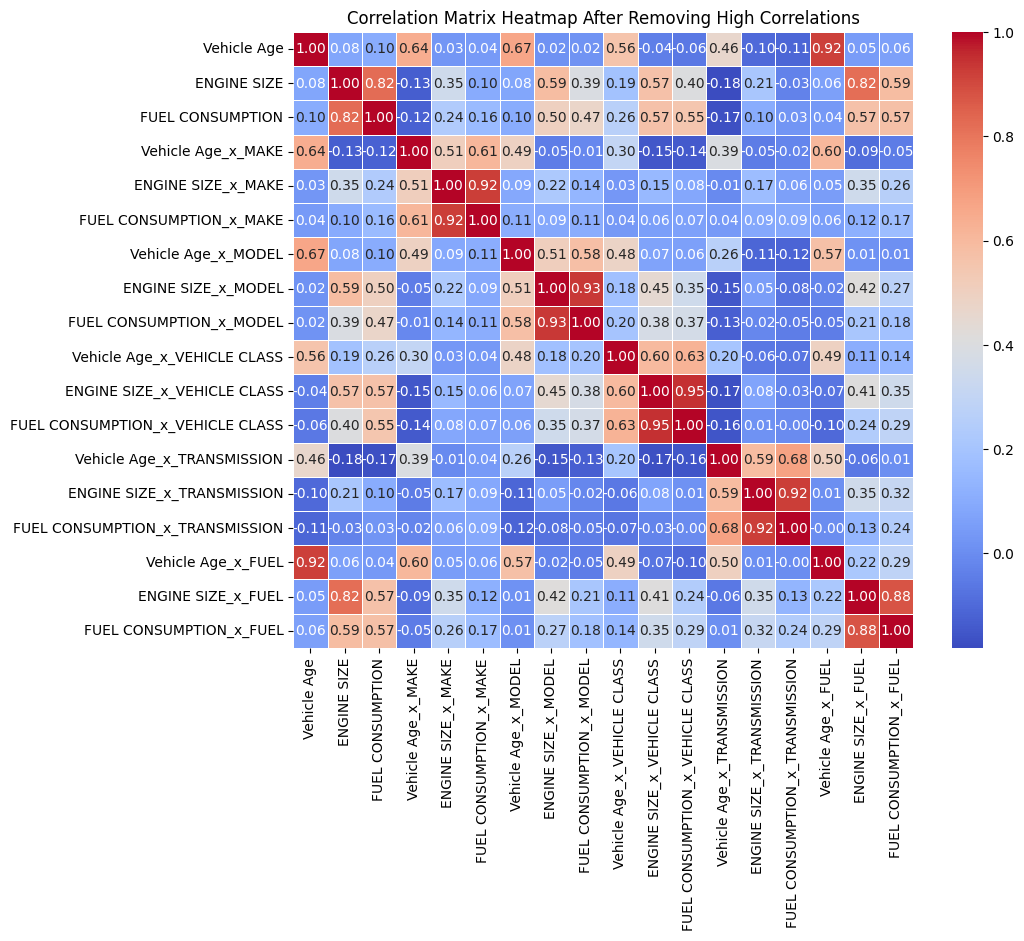

In [ ]:
# יצירת מפת חום להצגת מטריצת הקורלציות לאחר הסינון
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix Heatmap After Removing High Correlations")
plt.show()


In [ ]:
df.to_csv("cleaned_data.csv", index=False)